<a href="https://colab.research.google.com/github/chomsky8b/cryptoind/blob/main/Copy_of_cryptoind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm.notebook import tqdm

In [2]:
import requests
from bs4 import BeautifulSoup
import csv
from datetime import datetime, timedelta
def scrape_and_store_data(numdays = 365):
    # Get today's date
    today = datetime.now()

    # Open CSV file in append mode
    with open('crypto_data_year.csv', 'a', newline='') as file:
        writer = csv.writer(file)

        # Iterate over 365 days
        for i in tqdm(range(numdays)):
            # Calculate the date for the URL
            date_str = (today - timedelta(days=i)).strftime('%Y-%m-%d')
            url = f"https://coincodex.com/historical-data/crypto/?date={date_str}"

            # Send a GET request to the URL
            response = requests.get(url)

            # Check if the request was successful
            if response.status_code == 200:
                # Parse the HTML content of the page
                soup = BeautifulSoup(response.content, 'html.parser')

                # Find all rows of the table containing cryptocurrency data
                rows = soup.find_all('tr', class_='coin')

                # Iterate over each row and extract relevant data
                for row in rows:
                    # Extract data from the row
                    ticker_elem = row.find(class_='ticker')
                    open_elem = row.find(class_='price')
                    volume_elem = row.find(class_='volume')
                    market_cap_elem = row.find(class_='market-cap')

                    # Check if all elements are found
                    if ticker_elem and open_elem and volume_elem and market_cap_elem:
                        ticker = ticker_elem.text.strip()
                        open_price = open_elem.text.strip().replace('$', '').replace(',', '')
                        volume = volume_elem.text.strip().replace('$', '').replace(',', '')
                        market_cap = market_cap_elem.text.strip().replace('$', '').replace(',', '')

                        # Write the data to the CSV file
                        writer.writerow([date_str, ticker, open_price, volume, market_cap])
                    else:
                        #print("Failed to extract data from a row.")
                        print("1")

                #print(f"Data for {date_str} has been scraped and stored successfully!")
            else:
                print(f"Failed to retrieve data for {date_str} from the website.")

In [ ]:
scrape_and_store_data(2000)

In [ ]:
df = pd.read_csv("crypto_data_year.csv", parse_dates = [0], header=None)

In [ ]:
files.download("crypto_data_year.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.columns = ["Date","Currency", "Price", "Volume", "MarketCap"]


In [ ]:
def convert_currency(x):
    # Remove any non-standard white-space and possible 'M' (millions) if present
    x = x.replace('\u202f', '').replace(',', '')
    try:
      if x.endswith('B'):
        return float(x.replace('B', '')) * 1e9
      elif x.endswith('T'):
        return float(x.replace('T', '')) * 1e12
      elif x.endswith('M'):  # Assuming you might have 'M' for millions as well
        return float(x.replace('M', '')) * 1e6
      else:
        return float(x)
    except:
      return np.nan

# Apply the conversion
df['Volume'] = df['Volume'].apply(convert_currency)
df['MarketCap'] = df['MarketCap'].apply(convert_currency)
df['Price'] = df['Price'].apply(convert_currency)



In [ ]:
# Define the tickers to remove
tickers_to_remove = ['USDT', 'USDC']

df = df[~df['Currency'].isin(tickers_to_remove)]
df.sort_values(by = "Date", inplace=True)

<ipython-input-55-9357666ee3b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by = "Date", inplace=True)


In [ ]:
df = df.drop_duplicates(subset=['Date', 'Currency'], keep='first')

In [ ]:
indict = {}
weightdict = []
for i, j in df.groupby('Date'):
  j = j.nlargest(20,"Volume").reset_index(drop=True)
  w = np.sqrt(j['MarketCap'])
  weightdf = pd.DataFrame(w/j["Price"]/100000)
  weightdf["Date"] = i
  weightdf["Currency"] = j["Currency"]
  weightdf["TotalCap"] = w/1000
  weightdf['Price'] = j['Price']
  weightdf.columns = ["Weight", "Date", "Currency", "TotalCap", "Price"]
  weightdict.append(weightdf)
  indict[i] = np.sum(w)

In [ ]:
indser = pd.Series(indict)
indser.name = "Index"
weightdf = pd.concat(weightdict, ignore_index=True)

<Axes: >

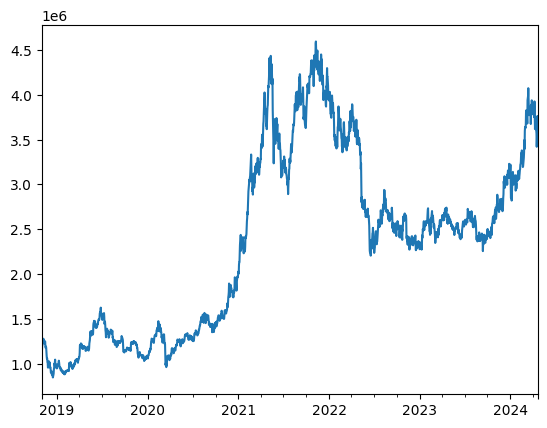

In [ ]:
indser.plot()

In [ ]:
weightdf[weightdf["Date"]=='2024-01-01']

,Weight,Date,Currency,TotalCap,Price
37760,0.000214,2024-01-01,BTC,915.576321,42799.000000
37761,0.002277,2024-01-01,ETH,527.702568,2317.050000
37762,0.020227,2024-01-01,SOL,212.508823,105.060000
37763,0.081853,2024-01-01,FIL,59.916609,7.320000
37764,0.058355,2024-01-01,ICP,77.846002,13.340000
37765,0.424351,2024-01-01,FDUSD,42.426407,0.999795
37766,0.005212,2024-01-01,ORDI,40.249224,77.230000
37767,0.006978,2024-01-01,BNB,217.370651,311.500000
37768,2.952188,2024-01-01,XRP,183.330303,0.620998
37769,0.282068,2024-01-01,ARB,45.166359,1.601260


In [ ]:
btcw = weightdf[weightdf["Currency"] == "BTC"]
btcw.set_index("Date", inplace=True)

<Axes: xlabel='Date'>

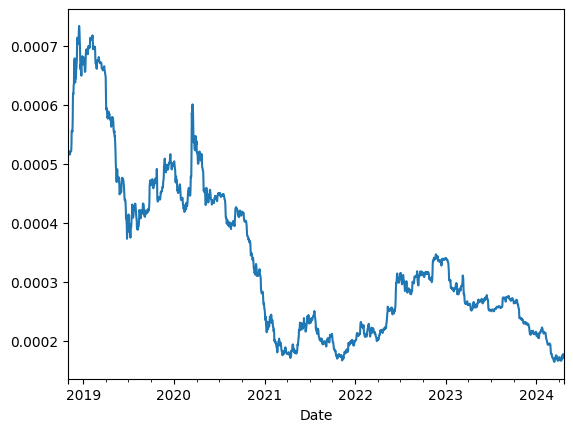

In [ ]:
btcw.Weight.plot()

In [ ]:
indser.describe()

count    2.000000e+03
mean     2.352367e+06
std      1.011612e+06
min      8.483555e+05
25%      1.321266e+06
50%      2.451090e+06
75%      3.129489e+06
max      4.592469e+06
Name: Index, dtype: float64

In [ ]:
indser.pct_change().describe()

count    1999.000000
mean        0.000777
std         0.020821
min        -0.105860
25%        -0.011491
50%         0.000875
75%         0.013249
max         0.078049
Name: Index, dtype: float64

In [ ]:
df[df.Currency == "BTC"].Price.pct_change().describe()

count    1999.000000
mean        0.001571
std         0.028447
min        -0.215893
25%        -0.010556
50%         0.001073
75%         0.013117
max         0.181642
Name: Price, dtype: float64

In [ ]:
weight_pivot = weightdf.pivot(index='Date', columns='Currency', values='Weight').fillna(value= 0)

In [ ]:
weight_pivot.head()

Currency,1INCH,AAVE,ABT,ADA,AE,AGIX,ALGO,AMPL,ANKR,APE,...,XNO,XRP,XTZ,XVG,YFI,YFII,ZB,ZEC,ZIL,ZRX
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-31,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.012447,0.0,0.0,0.0,0.0,0.0,0.002122,4.795231,0.000000
2018-11-01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.989061,0.0,0.0,0.0,0.0,0.0,0.002116,4.762154,0.000000
2018-11-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.959079,0.0,0.0,0.0,0.0,0.0,0.002096,4.675472,0.000000
2018-11-03,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.967153,0.0,0.0,0.0,0.0,0.0,0.002096,0.000000,0.260486
2018-11-04,0.0,0.0,0.0,5.887004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.963245,0.0,0.0,0.0,0.0,0.0,0.002080,0.000000,0.000000


In [ ]:
weight_pivot_d = weight_pivot.diff()

In [ ]:
price_pivot = weightdf.pivot(index='Date', columns='Currency', values='Price').fillna(value= 0)

In [ ]:
volpivot = weight_pivot_d * price_pivot

In [ ]:
volpivot.head()

Currency,1INCH,AAVE,ABT,ADA,AE,AGIX,ALGO,AMPL,ANKR,APE,...,XNO,XRP,XTZ,XVG,YFI,YFII,ZB,ZEC,ZIL,ZRX
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.010523,0.0,0.0,0.0,0.0,0.0,-0.000779,-0.001145,0.000000
2018-11-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.013766,0.0,0.0,0.0,0.0,0.0,-0.002313,-0.003119,0.000000
2018-11-03,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003688,0.0,0.0,0.0,0.0,0.0,-0.000044,-0.000000,0.209418
2018-11-04,0.0,0.0,0.0,0.439318,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.001789,0.0,0.0,0.0,0.0,0.0,-0.001900,0.000000,-0.000000


In [ ]:
totaltrans = np.abs(volpivot).sum(axis=1)

In [ ]:
totaltrans.head()

Date
2018-10-31    0.000000
2018-11-01    0.621556
2018-11-02    0.873676
2018-11-03    0.446956
2018-11-04    0.713222
dtype: float64

In [ ]:
indser.head()

2018-10-31    1.180198e+06
2018-11-01    1.154241e+06
2018-11-02    1.206310e+06
2018-11-03    1.209949e+06
2018-11-04    1.243313e+06
Name: Index, dtype: float64

In [ ]:
ind_trans = pd.concat([indser, totaltrans], axis=1)

In [ ]:
ind_trans.columns = ["Index", "TotalTrans"]

In [ ]:
ind_trans.head()

,Index,TotalTrans
2018-10-31,1.180198e+06,0.000000
2018-11-01,1.154241e+06,0.621556
2018-11-02,1.206310e+06,0.873676
2018-11-03,1.209949e+06,0.446956
2018-11-04,1.243313e+06,0.713222


In [ ]:
ind_trans["Frac"] = (ind_trans["TotalTrans"]/ind_trans["Index"]).dropna()

In [ ]:
ind_trans.describe()

,Index,TotalTrans,Frac
count,2.000000e+03,2000.000000,2.000000e+03
mean,2.352367e+06,0.981594,3.787868e-07
std,1.011612e+06,0.860609,2.343792e-07
min,8.483555e+05,0.000000,0.000000e+00
25%,1.321266e+06,0.343422,2.071187e-07
50%,2.451090e+06,0.724000,3.434707e-07
75%,3.129489e+06,1.384673,5.129413e-07
max,4.592469e+06,6.752337,1.588782e-06


In [ ]:
ind_trans["FracAnnualized"] = ind_trans["Frac"] * 365

In [ ]:
ind_trans.describe()

,Index,TotalTrans,Frac,FracAnnualized
count,2.000000e+03,2000.000000,2.000000e+03,2000.000000
mean,2.352367e+06,0.981594,3.787868e-07,0.000138
std,1.011612e+06,0.860609,2.343792e-07,0.000086
min,8.483555e+05,0.000000,0.000000e+00,0.000000
25%,1.321266e+06,0.343422,2.071187e-07,0.000076
50%,2.451090e+06,0.724000,3.434707e-07,0.000125
75%,3.129489e+06,1.384673,5.129413e-07,0.000187
max,4.592469e+06,6.752337,1.588782e-06,0.000580


<Axes: >

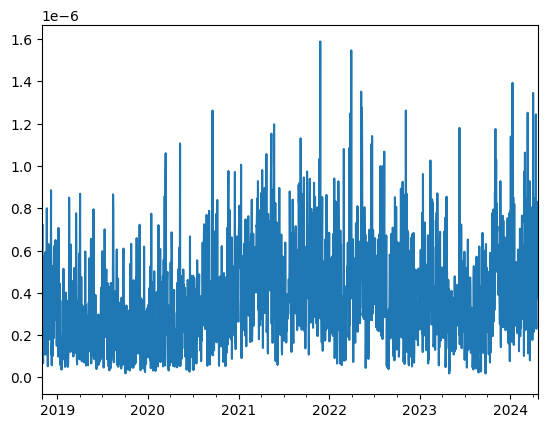

In [ ]:
ind_trans.Frac.plot()

In [ ]:
volpivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2018-10-31 to 2024-04-21
Columns: 181 entries, 1INCH to ZRX
dtypes: float64(181)
memory usage: 2.8 MB
